# This notebook contains:
* Function for plotting him8 ch13BT under the 4 wind regimes in a four panel figure (including topography)
* Function for plotting the mean ch13BT across all periods in one plot with a secondary panel showing topography

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
from numpy import s_
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from collections import defaultdict
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from scipy.interpolate import griddata
from datetime import datetime
import pandas as pd

# Open Bathymetry dataset for masking land/ocean

In [2]:
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))
bathlon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
bathlat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
bathlon, bathlat = np.meshgrid(bathlon, bathlat)
dem = ds_bath['z'].data

0.3.0


# Open BARRA2 datasets for 850hPa winds

In [5]:
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

# Open Himawari-8 regridded files for channel 13 brightness temperature

In [180]:
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  # Check for the ".nc" file extension
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/"
files = him8_files(directory)

In [330]:
# years = [2016,2017,2018,2019,2020]
# months = [1,2,3]
ds_barra = xr.open_mfdataset('/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc',engine="netcdf4")
ds_barra['time'] = pd.to_datetime(ds_barra['time'])
ds_barra = ds_barra.sortby('time')
ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))

In [182]:
ds_regrid = xr.open_mfdataset(files,engine="netcdf4")
ds_regrid

<xarray.Dataset>
Dimensions:  (time: 10682, lat: 446, lon: 502)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2020-03-31T23:00:00
  * lat      (lat) float64 -22.0 -21.98 -21.96 -21.95 ... -14.03 -14.01 -13.99
  * lon      (lon) float64 143.0 143.0 143.0 143.1 ... 152.0 152.0 152.0 152.0
Data variables:
    ch13BT   (time, lat, lon) float32 dask.array<chunksize=(1, 446, 502), meta=np.ndarray>
Attributes:
    note:     2016 JFM ch13BT with smaller domain, natural satellite res (2km...

In [189]:
# 
# ds_regrid_copy = ds_regrid.copy()
# existing_time_steps = pd.DatetimeIndex(ds_regrid['time'].values)
# # Create a new range of time steps at hourly frequency
# new_time_steps = pd.date_range(start=existing_time_steps.min(), end=existing_time_steps.max(), freq='H')
# # Reindex the dataset with the new time steps
# ds_filled = ds_regrid_copy.reindex(time=new_time_steps)
# months = [4,5,6,7,8,9,10,11,12]
# ds_jfm = ds_filled.sel(time=~(ds_filled.time.dt.month.isin(months)))#['time.month'] == months))

In [188]:
wind_dir = barra.wind_dir.compute()
winds = wind_dir[(wind_dir>0)&(wind_dir<=90)]
wind_times = winds.time.values
bt_winds = ds_regrid.ch13BT.sel(time=wind_times,method='nearest')


In [148]:
hours = bt_winds.groupby(bt_winds.time.dt.hour)
diurnal_bt = []
diurnal_bt_median = []
for hour in np.arange(0,24,1):
    bt_mean = hours[hour].sel(lat=-16.2874,method='nearest').mean(dim=['time'],skipna=True) # willis: -16.2874; cairns: -16.817 #towns:-19.4198
    bt_median = hours[hour].sel(lat=-16.2874,method='nearest').median(dim=['time'],skipna=True) 
    print(hour)
    diurnal_bt.append(bt_mean.values) 
    diurnal_bt_median.append(bt_median.values) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
def data_hov_him8(barra_ds,winddir1,winddir2,ds,lat,winds=None,median=None):
    if winds==True:
        # wind data
        wind_dir = barra_ds.wind_dir.compute()
        winds = wind_dir[(wind_dir>winddir1)&(wind_dir<=winddir2)]
        wind_times = winds.time.values
        bt_winds = ds.ch13BT.sel(time=wind_times,method='nearest')
        # grouping by hour
        hours = bt_winds.groupby(bt_winds.time.dt.hour)
    else:
        hours = ds.ch13BT.groupby(ds.time.dt.hour)
    diurnal_bt = []
    diurnal_bt_median = []
    for hour in np.arange(0,24,1):
        bt_mean = hours[hour].sel(lat=lat,method='nearest').mean(dim=['time'],skipna=True) # willis: -16.2874; cairns: -16.817 #towns:-19.4198
        bt_median = hours[hour].sel(lat=lat,method='nearest').median(dim=['time'],skipna=True) 
        diurnal_bt.append(bt_mean.values) 
        diurnal_bt_median.append(bt_median.values) 
        print(hour)
    # changing to aest
    diurnal_bt_aest = np.roll(diurnal_bt,shift=10,axis=0) 
    diurnal_bt_med_aest = np.roll(diurnal_bt_median,shift=10,axis=0) 
    if median==True:
        double = np.concatenate([diurnal_bt_med_aest,diurnal_bt_med_aest])
    else:
        double = np.concatenate([diurnal_bt_aest,diurnal_bt_aest])
    return double
   

In [296]:
def plot_h8(data,data1,data2,data3,data4,levels1,levels2,levels3,levels4,min_bt,max_bt,step,title,site_lat,site_lon,coast_lon,four_plots=None):
    if four_plots==True:
        # setting up plot
        fig, ax = plt.subplots(2,2,figsize=(10,10))
        fig.patch.set_facecolor('white')
        # ne plot
        cf1=ax[0,1].contourf(ds_regrid.lon,np.arange(0,48,1),data1,levels=levels1,cmap='binary')
        ax[0,1].set_xticks([144,146,148,150,152])
        ax[0,1].set_yticks(np.arange(0,48,6))
        cbar1 = plt.colorbar(cf1)
        cbar1.set_label('Chanel 13 Brightness Temperature (K)',fontsize=10)
        # se plot
        cf2=ax[1,1].contourf(ds_regrid.lon,np.arange(0,48,1),data2,levels=levels2,cmap='binary')
        ax[1,1].set_xticks([144,146,148,150,152])
        ax[1,1].set_yticks(np.arange(0,48,6))
        cbar2 = plt.colorbar(cf2)
        # cbar2.set_label('Chanel 13 Brightness Temperature (K)',fontsize=15)
        # sw plot
        cf3=ax[1,0].contourf(ds_regrid.lon,np.arange(0,48,1),data3,levels=levels3,cmap='binary')
        ax[1,0].set_xticks([144,146,148,150,152])
        ax[1,0].set_yticks(np.arange(0,48,6))
        cbar3 = plt.colorbar(cf3)
        # nw plot
        cf4=ax[0,0].contourf(ds_regrid.lon,np.arange(0,48,1),data4,levels=levels4,cmap='binary')
        ax[0,0].set_xticks([144,146,148,150,152])
        ax[0,0].set_yticks(np.arange(0,48,6))
        cbar4 = plt.colorbar(cf4)
        
        # for colorbar plotting
        # cax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        # # Create a colorbar using the ScalarMappable from one of the subplots
        # sm = plt.cm.ScalarMappable(cmap=plt.cm.binary)
        # sm.set_array(levels)  # You need to set an array for the ScalarMappable
        
        # # Add the colorbar to the figure
        # cbar = plt.colorbar(sm, cax=cax)
        # cbar.set_label('Chanel 13 Brightness Temperature (K)',fontsize=15)
        
        # titles
        ax[0,0].set_ylabel('Hour (AEST)',fontsize=15)
        ax[1,0].set_ylabel('Hour (AEST)',fontsize=15)
        ax[1,1].set_xlabel('Longitude',fontsize=15)
        ax[1,0].set_xlabel('Longitude',fontsize=15)
        ax[0,0].set_title('NW',fontsize=15)
        ax[0,1].set_title('NE',fontsize=15)
        ax[1,0].set_title('SW',fontsize=15)
        ax[1,1].set_title('SE',fontsize=15)
        fig.suptitle('Hovmöller Plots for Wind Regimes: '+title,fontsize=20)
        # grids
        ax[0,0].grid(alpha=0.5)
        ax[0,1].grid(alpha=0.5)
        ax[1,0].grid(alpha=0.5)
        ax[1,1].grid(alpha=0.5)
        site=[]
        for i in np.arange(0,48,1):
            site.append(site_lon)#willis:149.9646 #towns:146.5509 #cairns:145.683
        # plot dashes for 
        ax[0,0].plot(site,np.arange(0,48,1),linestyle='--',linewidth=3)
        ax[0,1].plot(site,np.arange(0,48,1),linestyle='--',linewidth=3)
        ax[1,0].plot(site,np.arange(0,48,1),linestyle='--',linewidth=3)
        ax[1,1].plot(site,np.arange(0,48,1),linestyle='--',linewidth=3)
        # make twin axis for topography overlay
        ax1 = ax[0,0].twinx()
        ax2 = ax[0,1].twinx()
        ax3 = ax[1,0].twinx()
        ax4 = ax[1,1].twinx()
        # plot bathymetry
        long=ds_bath.sel(y=site_lat,method='nearest').drop('z')
        ax1.plot(long.x,ds_bath['z'].sel(y=site_lat,method='nearest'),color='limegreen',linewidth=2)
        ax1.set_ylim(0,5000)
        ax1.set_xlim(143,152)
        ax1.set_yticks([])
        ax2.plot(long.x,ds_bath['z'].sel(y=site_lat,method='nearest'),color='limegreen',linewidth=2)
        ax2.set_ylim(0,5000)
        ax2.set_xlim(143,152)
        ax2.set_yticks([])
        # ax2.set_ylabel('Meters',fontsize=15)
        ax3.plot(long.x,ds_bath['z'].sel(y=site_lat,method='nearest'),color='limegreen',linewidth=2)
        ax3.set_ylim(0,5000)
        ax3.set_xlim(143,152)
        ax3.set_yticks([])
        ax4.plot(long.x,ds_bath['z'].sel(y=site_lat,method='nearest'),color='limegreen',linewidth=2)
        ax4.set_ylim(0,5000)
        ax4.set_xlim(143,152)
        ax4.set_yticks([])
        # ax4.set_ylabel('Meters',fontsize=15)
    else:
        # setting up plot
        fig, ax = plt.subplots(2,1,figsize=(10,10),gridspec_kw={'height_ratios': [5, 1]})
        fig.patch.set_facecolor('white')
        levels = np.arange(min_bt,max_bt,step)
        cf=ax[0].contourf(ds_regrid.lon,np.arange(0,48,1),data,levels=levels,cmap='binary')
        ax[0].set_xticks([143,144,145,146,147,148,149,150,151,152])
        ax[0].set_yticks(np.arange(0,48,3))
        cb=plt.colorbar(cf,ax=ax[0])
        cb.set_label('Chanel 13 Brightness Temperature (K)',fontsize=15)
        ax[0].set_ylabel('Hour (AEST)',fontsize=15)
        # ax[0].set_xlabel('Longitude')
        ax[0].set_title('Brightness Temperature Hovmöller: '+title,fontsize=20,pad=15)
        ax[0].grid(alpha=0.5)
        site=[]
        coast=[]
        for i in np.arange(0,48,1):
            site.append(site_lon) #willis:149.9646 #towns:146.5509 #cairns:145.683
            coast.append(coast_lon) #145.6 #towns: 147.5 #cairns:145.9
        ax[0].plot(site,np.arange(0,48,1),label=title,linestyle='--',linewidth=3)
        ax[0].plot(coast,np.arange(0,48,1),label='Coastline',color='gold',alpha=0.5,linewidth=3,linestyle='--')
        ax[0].legend(fontsize=12,loc='upper left',bbox_to_anchor=(1.05, -0.07))
        # plot bathymetry
        long=ds_bath.sel(y=site_lat,method='nearest').drop('z')
        ax[1].set_position([0.125, 0.15, 0.62, 0.1])
        ax[1].plot(long.x,ds_bath['z'].sel(y=site_lat,method='nearest'),color='seagreen')
        ax[1].set_ylim(0,1300)
        ax[1].set_xlim(143,152)
        ax[1].set_ylabel('Meters',fontsize=15)
        ax[1].set_xlabel('Longitude',fontsize=15)
    return
    

In [346]:
 # willis: -16.2874; cairns: -16.817 #towns:-19.4198
data = data_hov_him8(barra,180,360,ds_regrid,-16.817,winds=False,median=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [347]:
dataNE = data_hov_him8(barra,0,90,ds_regrid,-16.817,winds=True,median=False)
dataSE = data_hov_him8(barra,90,180,ds_regrid,-16.817,winds=True,median=False)
dataSW = data_hov_him8(barra,180,270,ds_regrid,-16.817,winds=True,median=False)
dataNW = data_hov_him8(barra,270,360,ds_regrid,-16.817,winds=True,median=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


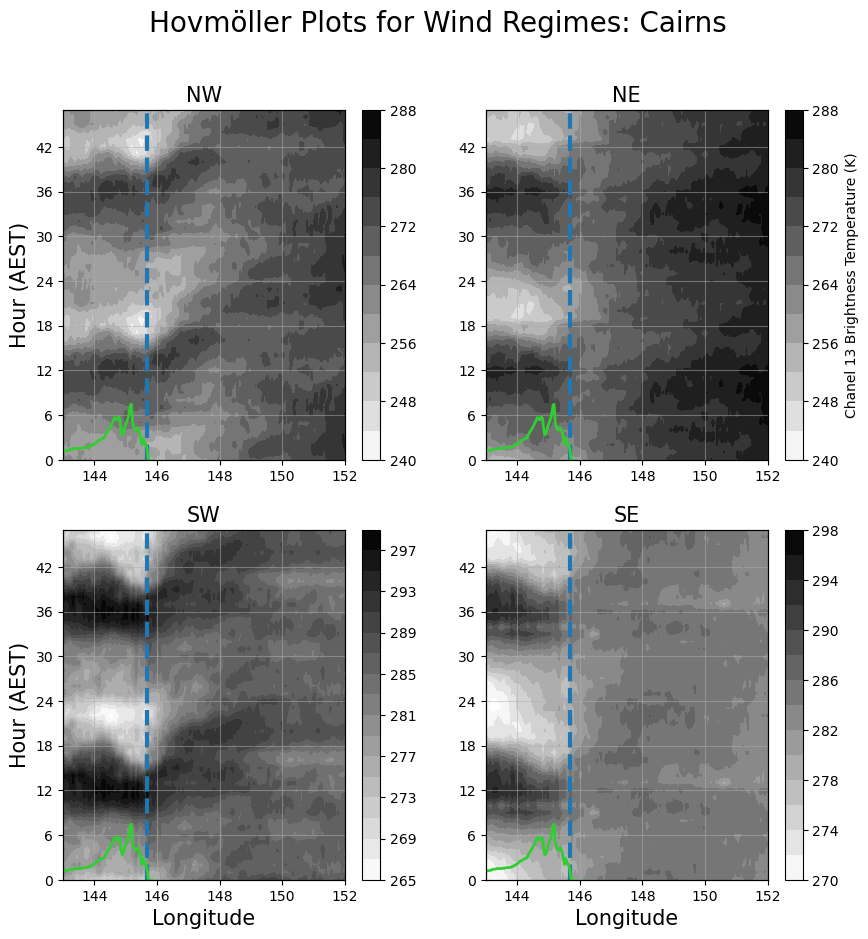

In [358]:
# plot_h8(data,data1,data2,data3,data4,levels1,levels2,levels3,levels4,min_bt,max_bt,step,title,site_lat,site_lon,coast_lon,four_plots=None)

# plot_h8(data,dataNE,dataSE,dataSW,dataNW,np.arange(250,300,4),np.arange(282,308,2),np.arange(260,310,3),np.arange(225,300,4),
#         250,300,2,'Townsville','-19.4198',146.5509,147.5,four_plots=True)  
plot_h8(data,dataNE,dataSE,dataSW,dataNW,np.arange(240,290,4),np.arange(270,300,2),np.arange(265,300,2),np.arange(240,290,4),
        250,300,2,'Cairns','-16.817',145.683,145.9,four_plots=True)   
# plot_h8(data,dataNE,dataSE,dataSW,dataNW,np.arange(245,295,4),np.arange(278,302,2),np.arange(275,302,2),np.arange(245,295,4),
#         250,300,2,'Willis Island','-16.2874',149.9646,145.6,four_plots=True)

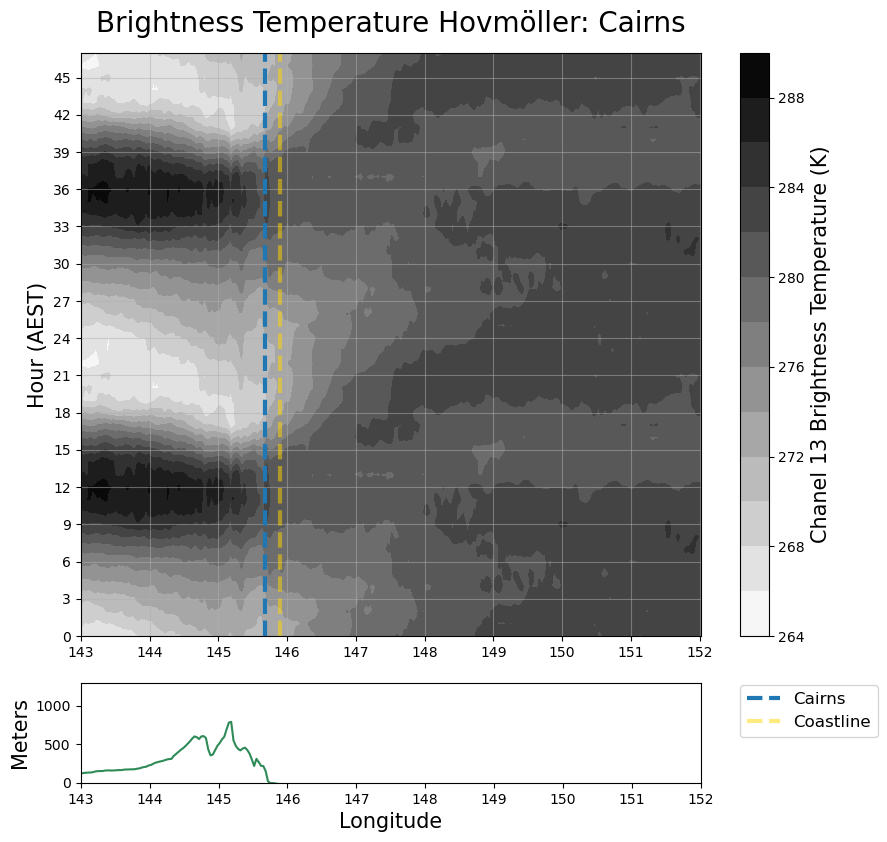

In [352]:
# plot_h8(data,dataNE,dataSE,dataSW,dataNW,np.arange(245,295,4),np.arange(278,302,2),np.arange(275,302,2),np.arange(245,295,4),
#         280,304,2,'Townsville','-19.4198',146.5509,147.5,four_plots=False)
plot_h8(data,dataNE,dataSE,dataSW,dataNW,np.arange(245,295,4),np.arange(278,302,2),np.arange(275,302,2),np.arange(245,295,4),
        264,292,2,'Cairns','-16.817',145.683,145.9,four_plots=False)   
# plot_h8(data,dataNE,dataSE,dataSW,dataNW,np.arange(245,295,4),np.arange(278,302,2),np.arange(275,302,2),np.arange(245,295,4),
#         270,300,2,'Willis Island','-16.2874',149.9646,145.6,four_plots=False)


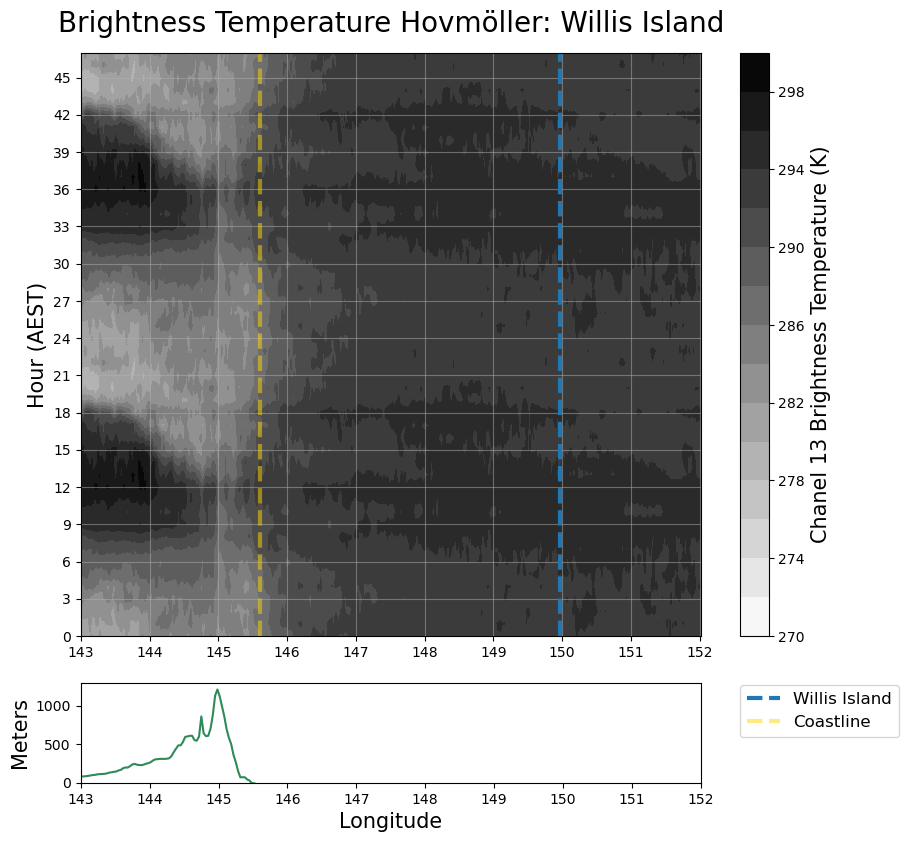

In [200]:
plot_h8(dataSE,270,302,2,'Willis Island','-16.2874',149.9646,145.6,four_plots=False)

In [9]:
%%time
from datetime import datetime
wind = wind_dir_towns[(wind_dir_towns>0*units("degree"))&(wind_dir_towns<90*units("degree"))]
wind_regime_files_ne = []
for hours in np.arange(0,24,1): # loop over each hour of the day
    for files in hourly_file_lists[hours]:                              # loop over each file in that hour
        fn = os.path.basename(files)                                    # extract filepath name
        date_string = fn[20:30]                                         # extract out datetime info from filename
        date_format = "%Y%j.%H"                                         # give file format
        date_time_obj = datetime.strptime(date_string, date_format)     # convert him8 filename date info to a datetime object
        print(fn[20:30])
        windtimes = wind.time.values
        windtimes.sort()
        for times in windtimes:                                         # loop over each time within BARRA-2 selected times (wind regime given above)
            date_strings = np.datetime_as_string(times, unit='s')       # convert each wind timestep to a datetime string
            date_formats = '%Y-%m-%dT%H:%M:%S'                          # give the date format
            datetime_obj = datetime.strptime(date_strings, date_formats)# convert barra2 wind info into a datetime object
            if datetime_obj==date_time_obj:                             # if the barra2 wind times = him8 time, append the him8 filepath to wind_regime_files
                wind_regime_files_ne.append(files)                         # output for this code gives shape (len(him8)=barra2 winds)

2016001.00
2016002.00
2016003.00
2016004.00
2016005.00
2016006.00
2016007.00
2016008.00
2016009.00
2016010.00
2016011.00
2016012.00
2016013.00
2016014.00
2016015.00
2016016.00
2016017.00
2016018.00
2016019.00
2016020.00
2016021.00
2016022.00
2016023.00
2016024.00
2016025.00
2016026.00
2016027.00
2016028.00
2016029.00
2016030.00
2016031.00
2016032.00
2016033.00
2016034.00
2016035.00
2016036.00
2016037.00
2016038.00
2016039.00
2016040.00
2016041.00
2016042.00
2016043.00
2016044.00
2016045.00
2016046.00
2016047.00
2016048.00
2016049.00
2016050.00
2016051.00
2016052.00
2016053.00
2016054.00
2016055.00
2016056.00
2016057.00
2016058.00
2016059.00
2016060.00
2016061.00
2016062.00
2016063.00
2016064.00
2016065.00
2016066.00
2016067.00
2016068.00
2016069.00
2016070.00
2016071.00
2016072.00
2016073.00
2016074.00
2016075.00
2016076.00
2016077.00
2016078.00
2016079.00
2016080.00
2016081.00
2016082.00
2016083.00
2016084.00
2016085.00
2016086.00
2016087.00
2016088.00
2016089.00
2016090.00
2016091.00